In [ ]:
import os

# Define root directory where the simulation files are located
root_directory = "/n17data/tersenov/SLICS/Cosmo_DES"

# Directories to exclude
exclude_dirs = ["SLICS_HR", "fid_a", "fid_f"]

# Open the master text file in write mode
master_file_path = "master_file.txt"
with open(master_file_path, "w") as master_file:
    # Iterate over the files and subdirectories in the root directory
    for root, dirs, files in os.walk(root_directory):
        # Exclude the specified directories
        dirs[:] = [d for d in dirs if d not in exclude_dirs]
        
        for file_name in files:
            # Write the file path to the master file
            file_path = os.path.join(root, file_name)
            master_file.write(file_path + "\n")

In [ ]:
import numpy as np

def process_files(file_paths):
    """Reads the information in the filename.

    Parameters
    ----------
    file_paths : list of str (.txt file)
        List containing the paths to the files to be processed

    Returns
    -------
    data : recarray
        Numpy recarray containing the information extracted from the file names

    """

    # Make empty recarray to store the data
    data = np.recarray(len(file_paths), dtype=[('id', int), ('seed', 'U1'), ('bin', int), ('LOS', int), ('tile', int)])

    # Iterate over the file paths and process each file
    for i, file_path in enumerate(file_paths):
        # Extract the file name from the file path
        file_name = file_path.split("/")[-1]
        
        # Split file name into parts
        file_parts = file_name.split("_")
        
        id = int(file_parts[2])
        seed = file_parts[3]
        unknown_number = int(file_parts[4])
        bin = int(file_parts[5][3:])  # Extract the number after "Bin"
        LOS = int(file_parts[6][3:])  # Extract the number after "LOS"
        tile = int(file_parts[7][1:-4])  # Extract the number after "R"

        # Assign the extracted data to the corresponding fields in the recarray
        data[i]['id'] = id
        data[i]['seed'] = seed
        data[i]['bin'] = bin
        data[i]['LOS'] = LOS
        data[i]['tile'] = tile
        # print(data[i])

    return data 

In [ ]:
# Read the file paths from master_file.txt
filename = "master_file.txt"
with open(filename, 'r') as file:
    file_paths = file.readlines()
    file_paths = [path.strip() for path in file_paths]

data = process_files(file_paths)

In [ ]:
def read_cosmo_params(file_path):
    """Reads the cosmological parameters from the .dat file.

    Parameters
    ----------
    file_path : str
        Path to the .dat file containing the cosmological parameters

    Returns
    -------
    cosmo_params : dict
        Dictionary mapping each ID to its corresponding cosmological parameters

    """

    cosmo_params = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Iterate over the lines starting from the second line
        for line in lines[1:]:
            line = line.strip()
            if line:
                parts = line.split()
                id = int(parts[0])
                params = {
                    'Om': float(parts[1]),
                    'h': float(parts[2]),
                    'w_0': float(parts[3]),
                    'sigma_8': float(parts[4]),
                    'Oc': float(parts[5])
                }
                cosmo_params[id] = params

    return cosmo_params

In [ ]:
# Path to the .dat file
dat_file_path = "/home/tersenov/shear-pipe-peaks/example/CosmoTable.dat"

# Read the cosmological parameters from the .dat file
cosmo_params = read_cosmo_params(dat_file_path)

# Map the IDs in the recarray to the corresponding cosmological parameters
mapped_params = []
for row in data:
    id = row['id']
    params = cosmo_params.get(id)
    if params:
        mapped_params.append(params)
    else:
        print(f"No parameters found for ID {id}")

# Now, 'mapped_params' will contain the corresponding cosmological parameters for each ID in the recarray

# Generate the mass map from the catalog, make the S/N maps and count the peaks

Catalog columns:

0. RA
1. DEC
2. e1_data
3. e2_data
4. w 
5. redshift_true_sim
6. gamma1_sim
7. gamma2_sim
8. kappa_sim
9. s_metacal_data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from lenspack.geometry.projections.gnom import radec2xy
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
import lenspack.peaks as peaks
from lenspack.starlet_l1norm import noise_coeff, get_l1norm_noisy
from lenspack.image.transforms import starlet2d
from astropy.stats import mad_std

In [2]:
# Constants and Parameters
CATALOG_FILE = "/n17data/tersenov/SLICS/Cosmo_DES/16_a/LOS4/DES_MocksCat_16_a_4_Bin3_LOS4_R4.dat"
N_GAL = 7
PIX_ARCMIN = 0.4
SHAPE_NOISE = 0.44
NSCALES = 5
NBINS = 40 
KAPPA_SNR = np.linspace(-2, 6, 31)

In [3]:
def read_catalog_data(catalog_data):
    ra = catalog_data[0]
    dec = catalog_data[1]
    g1_sim = catalog_data[6]
    g2_sim = catalog_data[7]
    kappa_sim = catalog_data[8]
    return ra, dec, g1_sim, g2_sim, kappa_sim

def create_kappa_map(ra, dec, g1_sim, g2_sim, size_x_deg=10, size_y_deg=10, pixel_size_emap_amin=0.4):
    x, y = radec2xy(np.mean(ra), np.mean(dec), ra, dec) # Project (ra,dec) -> (x,y)

    Nx = int(size_x_deg / pixel_size_emap_amin * 60)
    Ny = int(size_y_deg / pixel_size_emap_amin * 60)

    e1map, e2map = bin2d(x, y, npix=(Nx, Ny), v=(g1_sim, g2_sim)) # bin the shear field into a 2D map
    emap = np.array([e1map,e2map]) # stack the two components into a single array

    kappaE, kappaB = ks93(e1map, -e2map) # make kappa map (the minus sign has to be here for our data conventions)
    return kappaE, kappaB

def add_noise_to_kappa_map(kappa_map, shape_noise, n_gal, pix_arcmin):
    sigma_noise_CFIS = shape_noise / (np.sqrt(2 * n_gal * pix_arcmin**2))
    noise_map_CFIS_z05 = sigma_noise_CFIS * np.random.randn(kappa_map.shape[0], kappa_map.shape[1]) # generate noise map
    kappa_map_noisy = kappa_map + noise_map_CFIS_z05 # Add noise to the mass map
    return kappa_map_noisy, noise_map_CFIS_z05

def smooth_kappa_map(kappa_map, pixel_size_emap_amin):
    # Set the standard deviation of the Gaussian filter based on the pixel size of the kappa map
    precision_Peaks = 2 / pixel_size_emap_amin # pixel_size_emap_amin is the pixel size of the kappa map in arcminutes
    kappa_map_smoothed = ndi.gaussian_filter(kappa_map, precision_Peaks)
    return kappa_map_smoothed

def convert_to_snr_map(kappa_map_smoothed, noise_map_smoothed):
    snr_map = kappa_map_smoothed / np.std(noise_map_smoothed)
    return snr_map

def compute_multiscale_snr_maps(image, noise, nscales):
    """
    Compute SNR maps for each wavelet scale of a noisy image.
    
    Parameters:
        image (numpy.ndarray): The noiseless image.
        noise (numpy.ndarray): The noise to be added to the image.
        nscales (int): Number of wavelet scales for starlet decomposition.
        
    Returns:
        snr_maps (list of numpy.ndarray): List of SNR maps for each scale.
    """
    # Add noise to the noiseless image
    image_noisy = image + noise
    
    # Perform starlet decomposition
    image_starlet = starlet2d(image_noisy, nscales)
    
    # Estimate the noise level
    noise_estimate = mad_std(image_noisy)
    coeff_j = noise_coeff(image, nscales)
    
    snr_maps = []
    for image_j, std_co in zip(image_starlet, coeff_j):
        sigma_j = std_co * noise_estimate
        
        # Compute SNR map
        snr_map = image_j / sigma_j
        snr_maps.append(snr_map)
    
    return snr_maps

def compute_single_scale_peak_counts(snr_map, kappa_snr):
    """
    Compute peak counts for a single SNR map.

    Parameters:
        snr_map (numpy.ndarray): SNR map.
        kappa_snr (numpy.ndarray): Array of kappa values corresponding to the SNR map.

    Returns:
        kappa_th_center_snr (numpy.ndarray): Array of kappa threshold centers for peak counts.
        peak_counts (numpy.ndarray): Peak counts for the given SNR map.
    """
    kappa_th_center_snr = 0.5 * (kappa_snr[:-1] + kappa_snr[1:])
    peak_counts = peaks.peaks_histogram(snr_map, kappa_snr)[0]
    return kappa_th_center_snr, peak_counts


def compute_multiscale_peak_counts(snr_maps, kappa_snr):
    """
    Compute peak counts for each wavelet scale of SNR maps.

    Parameters:
        snr_maps (list of numpy.ndarray): List of SNR maps for each scale.
        kappa_snr (numpy.ndarray): Array of kappa values corresponding to SNR maps.

    Returns:
        kappa_th_center_snr (numpy.ndarray): Array of kappa threshold centers for peak counts.
        peak_counts (list of numpy.ndarray): List of peak counts for each scale.
    """
    kappa_th_center_snr = 0.5 * (kappa_snr[:-1] + kappa_snr[1:])
    
    peak_counts = [peaks.peaks_histogram(snr_map, kappa_snr)[0] for snr_map in snr_maps]

    return kappa_th_center_snr, peak_counts

def plot_map(map_data, title='', cmap='inferno', vmin=None, vmax=None):
    """
    Plot a 2D map using a colormap.

    Parameters:
        map_data (numpy.ndarray): The 2D map data.
        title (str): Title of the plot.
        cmap (str): Colormap name.
        vmin (float): Minimum value for colormap scaling.
        vmax (float): Maximum value for colormap scaling.
    """
    plt.figure()
    img = plt.imshow(map_data, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
    plt.title(title)
    plt.colorbar(img)
    plt.show()    

def plot_peak_count_histograms(kappa_th_center, peak_counts, title, xlabel, ylabel, log_scale=False):
    """
    Plot histograms of peak counts.

    Parameters:
        kappa_th_center (numpy.ndarray): Array of kappa threshold centers.
        peak_counts (numpy.ndarray or list of numpy.ndarray): Peak counts for each scale.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        log_scale (bool, optional): Whether to use a logarithmic scale for the y-axis. Default is False.
    """
    plt.figure()
    
    if isinstance(peak_counts, list):  # Multiscale case
        for scale, peak_count in enumerate(peak_counts):
            plt.plot(kappa_th_center, peak_count, label=f'Scale {scale + 1}')
    else:  # Single-scale case
        plt.plot(kappa_th_center, peak_counts)
    
    plt.legend()
    if log_scale:
        plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.title(title)
    plt.show()

def plot_l1norm_histograms(bins, l1norm_histogram, title, xlabel, ylabel, xlim=None, log_scale=False):
    """
    Plot L1-norm histograms for each scale.

    Parameters:
        bins (list of numpy.ndarray): List of bin edges for each scale.
        l1norm_histogram (list of numpy.ndarray): List of L1-norm histograms for each scale.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        xlim (tuple or list): Limits for the x-axis (e.g., xlim=(0, 6)).
        log_scale (bool): Whether to use a logarithmic scale for the y-axis.
    """
    plt.figure()

    for scale, l1norm_hist in enumerate(l1norm_histogram):
        plt.plot(bins[scale], l1norm_hist, label=f'Scale {scale}')

    plt.legend()
    plt.xticks()
    plt.yticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.title(title)
    
    if xlim:
        plt.xlim(xlim)
        
    if log_scale:
        plt.yscale('log')
        
    plt.show()


Loading catalog

In [4]:
# Load the catalog data as a numpy array
catalog_data = np.loadtxt(CATALOG_FILE)
catalog_data = catalog_data.T
ra, dec, g1_sim, g2_sim, kappa_sim = read_catalog_data(catalog_data)

Create kappa map and make an SNR map from it

In [5]:
# Create kappa map
kappaE, _ = create_kappa_map(ra, dec, g1_sim, g2_sim)

# Add noise to the kappa map
kappaE_noisy, noise_map_CFIS_z05 = add_noise_to_kappa_map(kappaE, SHAPE_NOISE, N_GAL, PIX_ARCMIN)

# Smooth the noisy kappa map
kappaE_noisy_smoothed = smooth_kappa_map(kappaE_noisy, PIX_ARCMIN) 

# Compute SNR map
snr = convert_to_snr_map(kappaE_noisy_smoothed, kappaE_noisy_smoothed)

Peak counts on the SNR map

In [6]:
# Compute peak counts 
kappa_th_center_snr, peak_counts_single = compute_single_scale_peak_counts(snr, KAPPA_SNR)

Multiscale SNR maps

In [7]:
# Compute multiscale SNR maps
multiscale_snr_maps = compute_multiscale_snr_maps(kappaE, noise_map_CFIS_z05, NSCALES)

In [8]:
# Compute peak counts for each scale
kappa_th_center_snr, peak_counts_multi = compute_multiscale_peak_counts(multiscale_snr_maps, KAPPA_SNR)

$\ell_1$-norm

In [9]:
# Call the function to compute the L1-norm histogram
bins_l1, l1norm_histogram = get_l1norm_noisy(kappaE, noise_map_CFIS_z05, NSCALES, NBINS*2)

# Plotting

Plot:
1. Noiseless mass map
2. Noisy mass map
3. Noisy smoothed mass map
4. SNR map

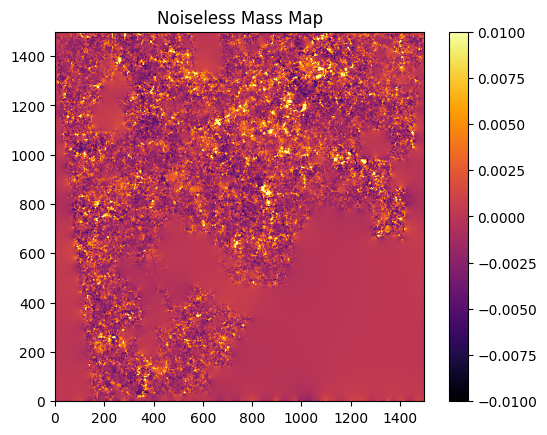

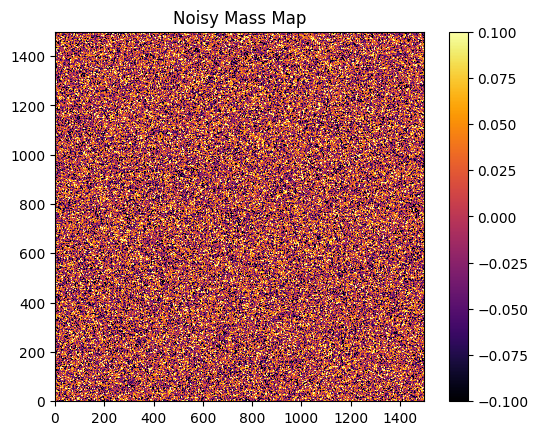

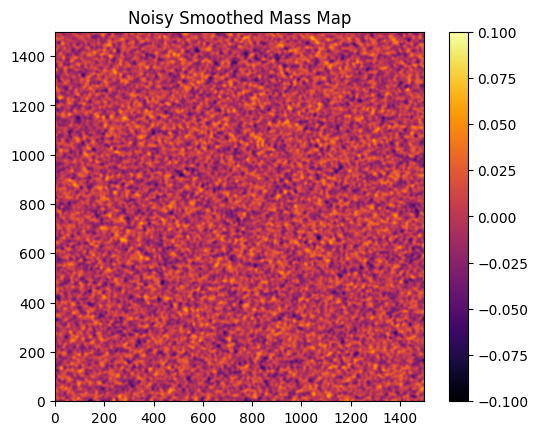

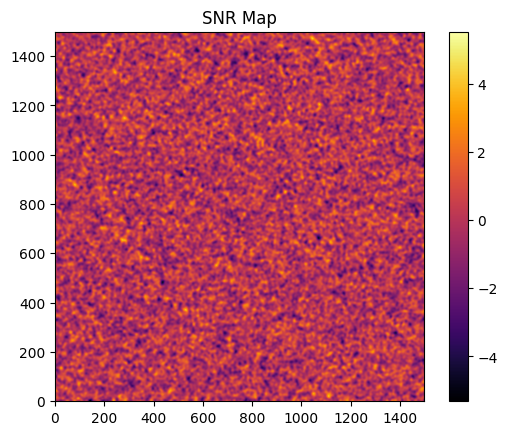

In [10]:
# Define the map data and titles
map_data = [kappaE, kappaE_noisy, kappaE_noisy_smoothed, snr]
titles = ['Noiseless Mass Map', 'Noisy Mass Map', 'Noisy Smoothed Mass Map', 'SNR Map']

# Define the vmin and vmax values for each map (adjust these values as needed)
vmin_values = [-0.01, -0.1, -0.1, None]
vmax_values = [0.01, 0.1, 0.1, None]

# Plot each map using the plot_map function
for data, title, vmin, vmax in zip(map_data, titles, vmin_values, vmax_values):
    plot_map(data, title=title, vmin=vmin, vmax=vmax)

Plot the SNR maps of the 5 different scales and the coarse map

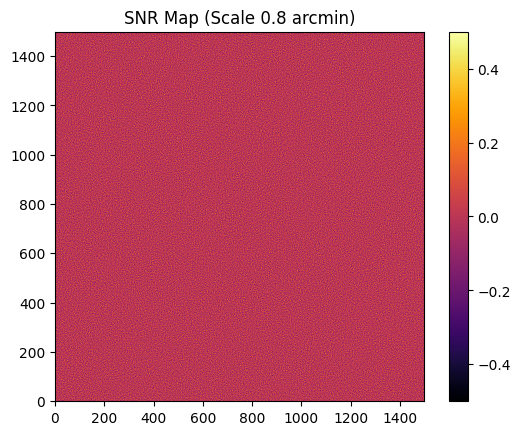

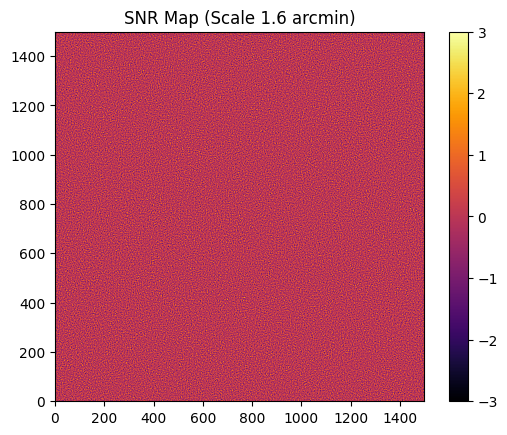

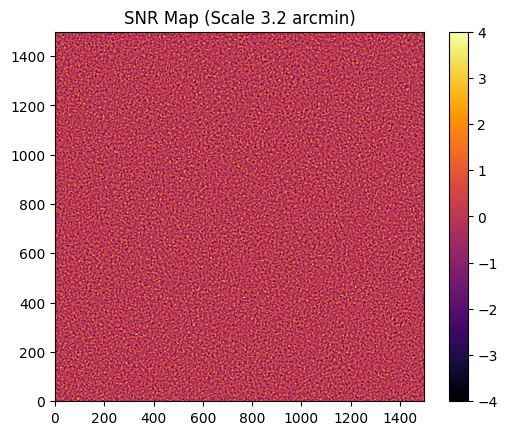

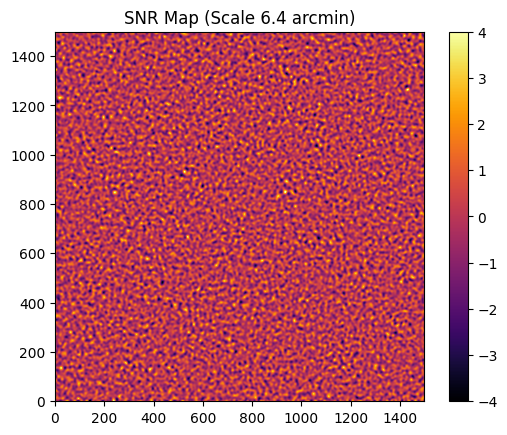

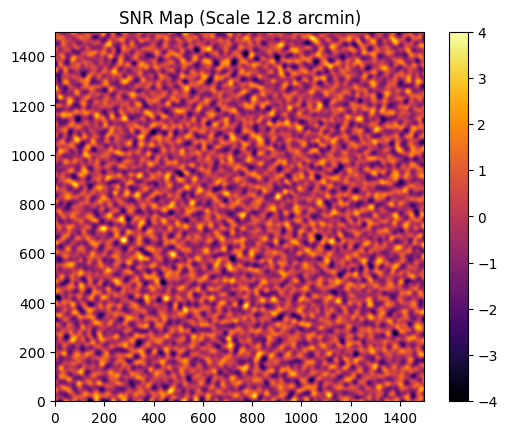

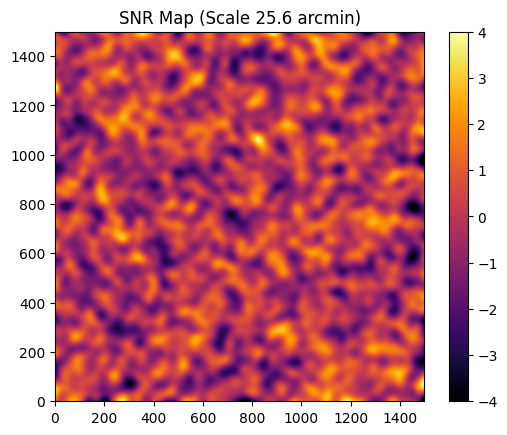

In [11]:
# Define vmin and vmax values for each SNR map
vmin_values = [-0.5, -3, -4, -4, -4, -4]  # Replace with your desired vmin values
vmax_values = [0.5, 3, 4, 4, 4, 4]  # Replace with your desired vmax values

scales_arcmin = [2**(i+1) * PIX_ARCMIN for i in range(len(multiscale_snr_maps))]

for i, (snr_map, scale_arcmin) in enumerate(zip(multiscale_snr_maps, scales_arcmin)):
    title = f"SNR Map (Scale {scale_arcmin:.1f} arcmin)"
    plot_map(snr_map, title=title, cmap='inferno', vmin=vmin_values[i], vmax=vmax_values[i])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


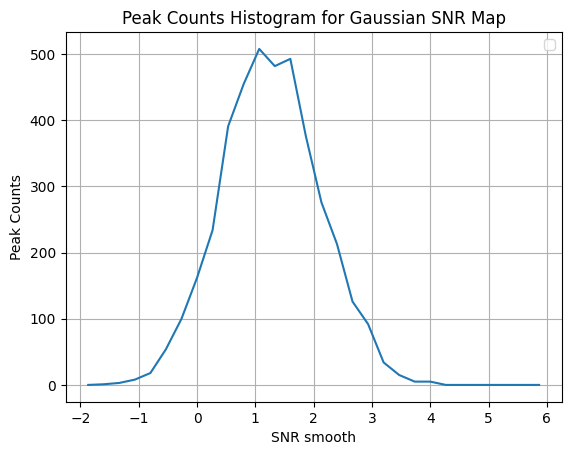

In [12]:
# Plot single-scale peak count histogram
plot_peak_count_histograms(kappa_th_center_snr, peak_counts_single, 
                           'Peak Counts Histogram for Gaussian SNR Map', 'SNR smooth', 'Peak Counts')

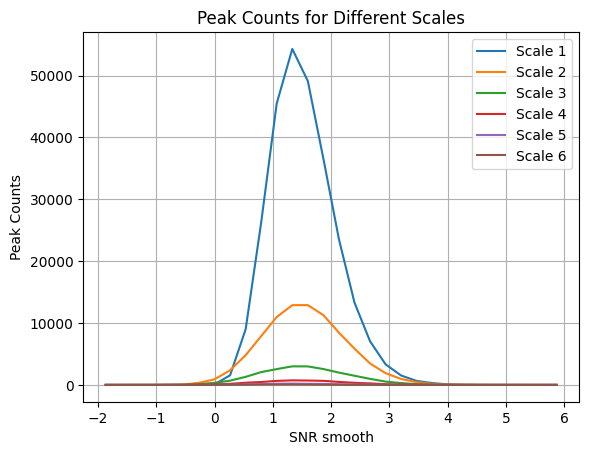

In [17]:
# Plot multiscale peak count histograms
plot_peak_count_histograms(kappa_th_center_snr, peak_counts_multi, 
                           'Peak Counts for Different Scales', 'SNR smooth', 'Peak Counts', log_scale=False)

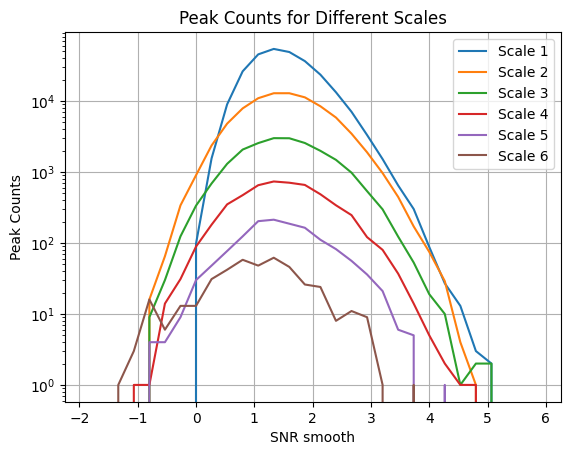

In [16]:
# Plot multiscale peak count histograms
plot_peak_count_histograms(kappa_th_center_snr, peak_counts_multi, 
                           'Peak Counts for Different Scales', 'SNR smooth', 'Peak Counts', log_scale=True)

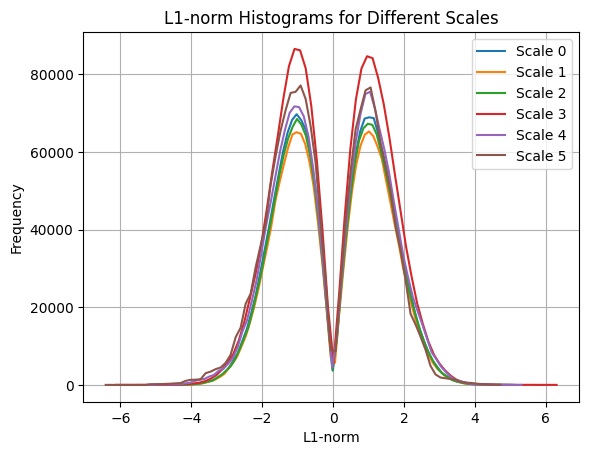

In [19]:
# Plot l1-norm histograms for different scales
plot_l1norm_histograms(bins_l1, l1norm_histogram, 'L1-norm Histograms for Different Scales', 'L1-norm', 'Frequency')